In [2]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Models

In the United States, many diners will leave a tip for their waiter or waitress as the diners pay for the meal. Although it is customary in the US to offer 15\% of the total bill as tip, perhaps some restaurants have more generous patrons than others.

One particular waiter was so interested in how much tip he could expect to get that he collected information about all the tables he served during a month of employment.

In [3]:
# HIDDEN
tips = sns.load_dataset('tips')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
...,...,...,...,...,...,...,...
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


We can plot a histogram of the tip amounts:

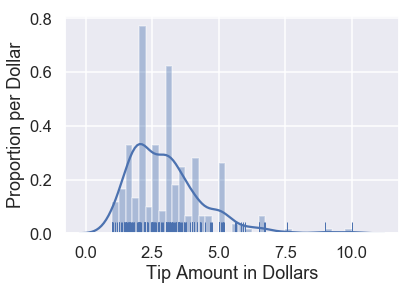

In [4]:
# HIDDEN
sns.distplot(tips['tip'], bins=np.arange(0, 10.1, 0.25), rug=True)
plt.xlabel('Tip Amount in Dollars')
plt.ylabel('Proportion per Dollar');

There are already some interesting patterns in the data. For example, there is a clear mode at $\$2$ and most tips seem to be in multiples of $\$0.50$.

For now, we are most interested in the percent tip: the tip amount divided by the bill amount. We can create a column in our DataFrame for this variable and show its distribution.

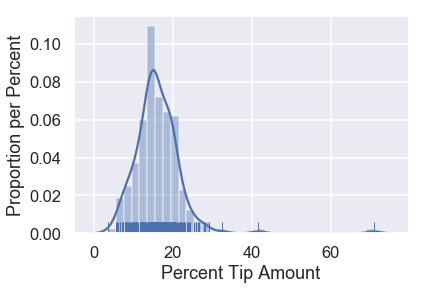

In [5]:
# HIDDEN
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100
sns.distplot(tips['pcttip'], rug=True)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

It looks like one table left our waiter a tip of $70\%$! However, most of the tips percentages are under $30\%$. Let's zoom into that part of the distribution.

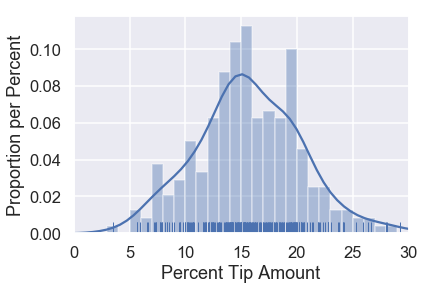

In [6]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)
plt.xlim(0, 30)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

We can the distribution is roughly centered at $15\%$ with another potential mode at $20\%$. Suppose our waiter is interested in predicting how much percent tip he will get from a given table. To address this question, we can create a model for how much tip the waiter will get.

### A Simple Model

One simple model is ignore the data altogether and state that since the convention in the U.S. is to give 15\% tip, the waiter will always get 15\% tip from his tables. While extremely simple, we will use this model to define some variables that we'll use later on.

This model assumes that there is one true percentage tip that all tables, past and future, will give the waiter. This is the *population parameter* for the percent tip, which we will denote by $ \theta^* $.

After making this assumption, our model then says that our guess for $ \theta^* $ is $15\%$. We will use $ \theta $ to represent our current guess.

In mathematical notation, our model states that:

$$ \theta = 15 $$

This model is clearly problematic—if the model were true, every table in our dataset should have given the waiter exactly 15\% tip. Nonetheless, this model will make a reasonable guess for many scenarios. In fact, this model might be the most useful choice if we had no other information aside from the fact that the waiter is employed in the US.

Since our waiter collected data, however, we can use his history of his tips to create a model instead of picking 15\% based on convention alone.

### Loss Function Intuition

The distribution of tip percents from our dataset is replicated below for convenience.

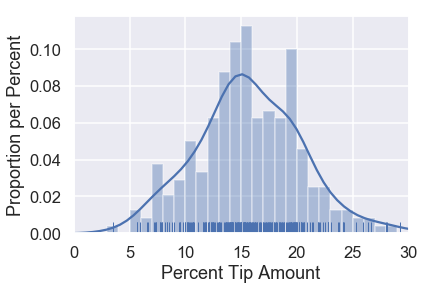

In [7]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)
plt.xlim(0, 30)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

Let's suppose we are trying to compare two choices for $\theta$: $10\%$ and $15\%$. We can mark both of these choices on our distribution:

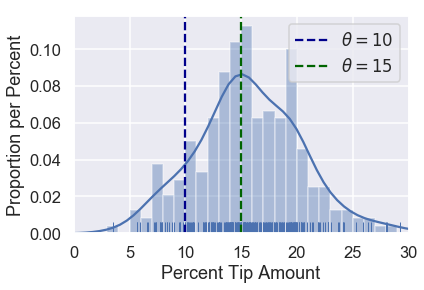

In [10]:
# HIDDEN
sns.distplot(tips['pcttip'], bins=np.arange(30), rug=True)

plt.axvline(x=10, c='darkblue', linestyle='--', label=r'$ \theta = 10$')
plt.axvline(x=15, c='darkgreen', linestyle='--', label=r'$ \theta = 15$')
plt.legend()

plt.xlim(0, 30)
plt.xlabel('Percent Tip Amount')
plt.ylabel('Proportion per Percent');

Intuitively, it looks like choosing $ \theta = 15 $ makes more sense than $ \theta = 10 $ given our dataset. Why is this? When we look at the points in our data, we can see that more points fall close to $15$ than they do to $10$.

Although it seems apparent that $ \theta = 15 $ is a better choice than $ \theta = 10 $, it is not so clear whether $ \theta = 15 $ is a better choice than $ \theta = 16 $. To make precise choices between different values of $ \theta $, we would like to assign each value of $ \theta $ a number that measures how "good" it is for our data. That is, we want a function that takes as input a value of $ \theta $ and the points in our dataset, outputting a single number that we will use to select the best value of $ \theta $ that we can.

We call this function a **loss function**.